# Gap Episode Probability

## Setup

In [1]:
# Common imports
import os
import sys

# Third-party imports
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

## Theory

The residuals time series originates from the difference between predicted consumption (baseline + estimated effect of user actions) and measured consumption (from the box). At each time step, we get an estimate and an uncertainty around this estimate, combining the uncertainty of the two models.

$$
\begin{aligned}
  e &= C_{baseline} + \Delta_{actions} - C_{observed}\\
  \\
  C_{baseline} &= f(X, t) + \varepsilon_{baseline}(t)\\
  C_{actions} &= g(X, t) + \varepsilon_{actions}(t)\\
  \\
  \varepsilon_{baseline} &= \mathcal{N}(0,\sigma_{baseline}(t)) \\
  \varepsilon_{actions} &= \mathcal{N}(0,\sigma_{actions}(t))
\end{aligned}
$$

So a model for $e$ is the non stationnary variance varying process :

$$
\begin{align}
  e &= \mathcal{N}(0,\sqrt{\sigma_{baseline}(t)^{2} + \sigma_{actions}(t)^{2}})
\end{align}
$$

We want to test if the sequence of observed residuals $e_{obs}$ is likely given this model, to flag the large deviations. The probability of observing a larger-than-usual deviation can be described as the probability of the random variable $|e|$ taking on a value greater than $|e_{obs}|$:

$$
\begin{align}
  P(|e| > |e_{obs}|) &= 1 - P(|e| \le |e_{obs}|)\\
\end{align}
$$

$P(|e| \le |e_{obs}|)$ being the cumulative distribution function of a half-normal distribution with mean zero and variance $\sigma_{baseline}(t)^{2} + \sigma_{actions}(t)^{2}$

With this function, $P \rightarrow 0$ for larger-than-usual (rare) deviations, while $P \rightarrow 1$ for small (common) deviations.

However, we then want to estimate the probability of non occurence of larger-than-usual deviations, described as the probability of the non occurence of the $N$ long sequence of residuals $[e_{obs}(t), ..., e_{obs}(t+N)]$ is :

$$
\begin{align}
  P(e_{obs}(t), ..., e_{obs}(t+k)) = \prod_{i=t}^N (1-P(|e(i)| > |e_{obs}(i)|))
\end{align}
$$

As it turns out this is equivalent to estimating the probability of occurence of small (common) deviations, that is the probability of the occurence of the $N$ long sequence of residuals $[e_{obs}(t), ..., e_{obs}(t+N)]$ is :

$$
\begin{align}
  P(e_{obs}(t), ..., e_{obs}(t+k)) = \prod_{i=t}^N P(|e(i)| \le |e_{obs}(i)|)
\end{align}
$$

Which means that we only need to compute the probability of observing small (common) deviations $P(|e| \le |e_{obs}|)$ in the first place, hence compute the cumulative distribution function of a half-normal distribution with mean zero and variance $\sigma_{baseline}(t)^{2} + \sigma_{actions}(t)^{2}$

This probability indicates how unlikely a sequence of larger-that-usual deviations is: if $P \rightarrow 0$ it is very common, and if $P \rightarrow 1$ it is very rare.

## Example

Let's create a time series with a $\mathcal{N}(0,\sigma(t))$ distribution, disturbed at some random time step :

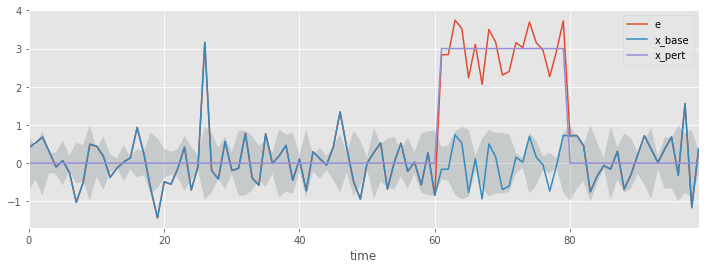

In [9]:
import numpy.random as rnd 

N = 100
time = np.arange(0,N)

# Base residual time series
sigmas = rnd.uniform(0.1, 1, N)
x_base = rnd.normal(0, sigmas)

# Perturbation
# (action from the user, behavior evolution...)
N_event = 20
N_start = rnd.choice(N - N_event, 1)
x_pert = np.repeat(0, N)
x_pert[np.arange(N_start, (N_start + N_event - 1), 1)] = 3

# Observed residuals 
e = x_base + x_pert

# Plot
df = pd.DataFrame({'time': time,
                   'x_base': x_base,
                   'x_pert': x_pert,
                   'e': e})
df = df.set_index('time')

df_p = df.copy() # Save dataframe for plots
df_p.plot(figsize=(12,4))
plt.fill_between(df_p.index, -sigmas, sigmas, facecolor="#7f8c8d", alpha=0.3, edgecolor='none')

Now we can compute the probability of each observed residual given its distribution, and the probability of the non occurence of the sequence of observations with a roling window :

In [10]:
from scipy.stats import norm, halfnorm

# Probability of each residual
df['sigmas'] = sigmas
df['p'] = halfnorm.cdf(abs(df.e), loc=0, scale=df.sigmas)

# Probability of each 2 time steps long residual sequence
w = 2
# Exp-Sum-Log function for computationally robust product of probabilities
expsumlog = lambda x: np.exp(np.sum(np.log(x)))

df['p_roll'] = df['p'].rolling(window=w, center=True).apply(expsumlog)

# Flag the "rare" sequences
df['flag'] = np.where(df['p'] > .95, True, False)
df

,e,x_base,x_pert,sigmas,p,p_roll,flag
time,,,,,,,
0,0.408009,0.408009,0,0.709478,0.434765,NaN,False
1,0.532263,0.532263,0,0.437310,0.776446,0.337571,False
2,0.683769,0.683769,0,0.853502,0.576946,0.447967,False
3,0.299502,0.299502,0,0.255732,0.758464,0.437592,False
4,-0.100783,-0.100783,0,0.284055,0.277262,0.210293,False
5,0.065218,0.065218,0,0.587122,0.088448,0.024523,False
6,-0.253072,-0.253072,0,0.201050,0.791880,0.070040,False
7,-1.024710,-1.024710,0,0.538265,0.943054,0.746786,False
8,-0.513903,-0.513903,0,0.463273,0.732694,0.690970,False


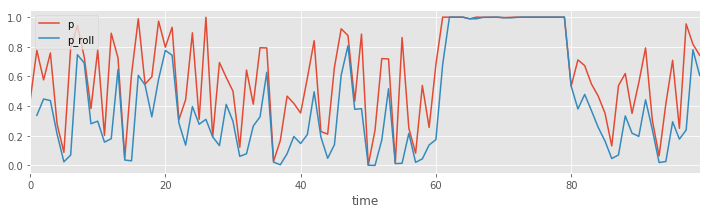

In [11]:
# Plot
df[['p','p_roll']].plot(figsize=(12,3))

flag
False    Axes(0.125,0.125;0.775x0.755)
True     Axes(0.125,0.125;0.775x0.755)
Name: e, dtype: object

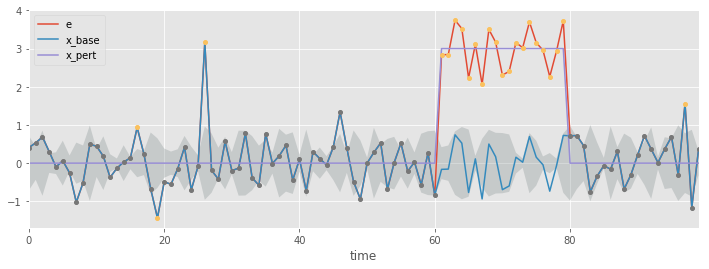

In [13]:
# Plot
df_p.plot(figsize=(12,4))
plt.fill_between(df_p.index, -sigmas, sigmas, facecolor="#7f8c8d", alpha=0.3, edgecolor='none')
df.groupby('flag')['e'].plot(style='o', ms=4)